# Redes Neurais para Regressão - Boston Housing

Aprendizados:
- Redes neurais para regressão
- Normalização dos dados
- Validação cruzada

In [80]:
from keras.datasets import boston_housing
from keras.callbacks import EarlyStopping
from keras import models, layers
from keras.utils import set_random_seed
import numpy as np
import matplotlib.pyplot as plt
import time
from copy import deepcopy
import warnings

warnings.filterwarnings("ignore")

In [2]:
### Loading the Boston housing dataset

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

#looking at the data
print(train_data.shape)
print(test_data.shape)

#the targets are the median values of owner-occupied homes, in thousands of dollars
print(train_targets)

(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 

**Preparando os dados**

In [3]:
### Normalizing the data

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

**Construindo a rede**
Devido ao número limitado de amostras disponíveis, usaremos uma rede muito pequena com duas camadas ocultas, cada uma com 64 unidades. Em geral, quanto menos dados de treinamento houver, pior será o *overfitting*, e usar uma rede pequena é uma maneira de mitigar o *overfitting*.

In [4]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

A rede termina com uma única unidade e sem ativação (será uma camada linear). Essa é uma configuração típica para regressão escalar (uma regressão em que você está tentando prever um único valor contínuo). Aplicar uma função de ativação restringiria o intervalo que a saída pode assumir; por exemplo, se você aplicasse uma função de ativação `sigmoid` à última camada, a rede só poderia aprender a prever valores entre 0 e 1. Aqui, porque a última camada é puramente linear, a rede está livre para aprender a prever valores em qualquer faixa.

Observe que estamos compilando a rede com a função de perda `mse` (*erro médio quadrático*), o quadrado da diferença entre as previsões e os alvos. Esta é uma função de perda amplamente utilizada para problemas de regressão.
Também estamos monitorando uma nova métrica durante o treinamento: o *erro médio absoluto* (`MAE`). É o valor absoluto da diferença entre as previsões e os alvos. Por exemplo, um `MAE` de 0.5 neste problema significaria que suas previsões têm um desvio médio de $500.

**Validando a abordagem usando validação K-fold**

Para avaliar sua rede enquanto continua ajustando seus parâmetros (como o número de épocas usado para o treinamento), você poderia dividir os dados em um conjunto de treinamento e um conjunto de validação, como fez nos exemplos anteriores. Mas, devido ao número limitado de pontos de dados, o conjunto de validação acabaria sendo muito pequeno (por exemplo, cerca de 100 exemplos). Como consequência, as pontuações de validação podem variar bastante dependendo de quais pontos de dados você escolheu para usar na validação e quais você escolheu para o treinamento: as pontuações de validação podem ter uma alta **variância** em relação à divisão de validação. Isso impediria que você avaliasse confiavelmente seu modelo.

A melhor prática em tais situações é usar a validação cruzada *K-fold*. Ela consiste em dividir os dados disponíveis em K partições (tipicamente K = 4 ou 5), instanciar K modelos idênticos e treinar cada um em K - 1 partições enquanto avalia na partição restante. A pontuação de validação para o modelo usado é então a média das K pontuações de validação obtidas. Em termos de código, isso é muito simples.

In [43]:
### K-fold validation

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],axis=0)
  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
  epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)
  print(f'\tFold # {i} MAE: {val_mae:.2f}')
print(all_scores)
np.mean(all_scores)

processing fold # 0
Fold # 0 MAE: 2.523258924484253
processing fold # 1
Fold # 1 MAE: 2.592108964920044
processing fold # 2
Fold # 2 MAE: 2.6593167781829834
processing fold # 3
Fold # 3 MAE: 2.7368087768554688
[2.523258924484253, 2.592108964920044, 2.6593167781829834, 2.7368087768554688]


2.6278733611106873

As diferentes execuções realmente mostram pontuações de validação bastante diferentes, de 2.6 a 3.2. A média (3.0) é uma métrica muito mais confiável do que qualquer pontuação única - esse é o ponto principal da validação cruzada K-fold. Neste caso, você está errando em média \$3000, o que é significativo considerando que os preços variam de \$10000 a \$50000.

Vamos tentar treinar a rede um pouco mais: 500 épocas. Para manter um registro de quão bem o modelo se sai a cada época, modificaremos o loop de treinamento para salvar o registro da pontuação de validação por época.

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


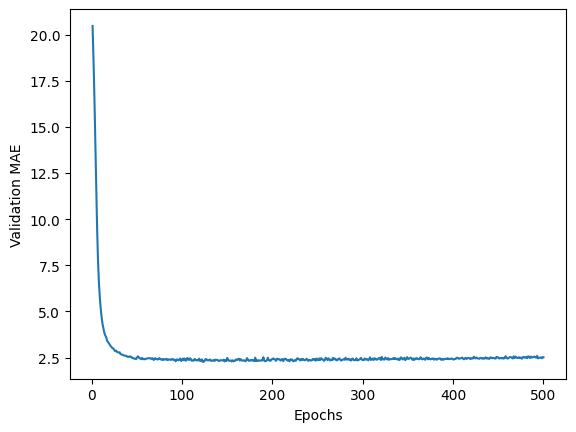

In [6]:
### Saving the validation logs at each fold

num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]], axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets,
    validation_data=(val_data, val_targets),
  epochs=num_epochs, batch_size=32, verbose=0)
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

### Building the history of successive mean K-fold validation scores
average_mae_history = [
np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### Plotting validation scores

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Pode ser um pouco difícil ver o gráfico, devido a problemas de escala e variância relativamente alta. Vamos fazer o seguinte:
- Omitir os primeiros 10 pontos de dados, que estão em uma escala diferente do resto da curva.
- Substituir cada ponto por uma média móvel exponencial dos pontos anteriores para obter uma curva suave.

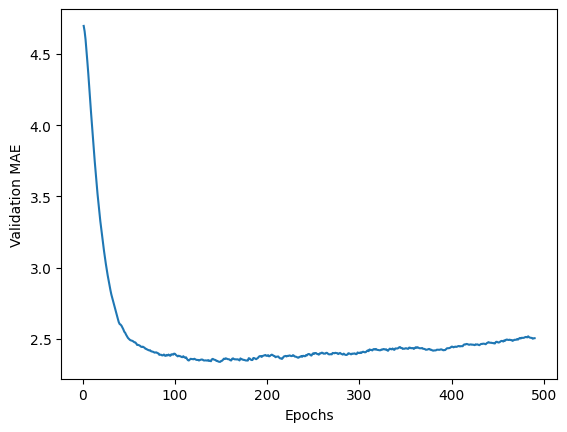

In [7]:
### Plotting validation scores, excluding the first 10 data points
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

De acordo com este gráfico, a validação por MAE para de melhorar significativamente após 80 épocas. Após esse ponto, começa-se a ter *overfitting*. Assim que terminarmos de ajustar outros parâmetros do modelo (além do número de épocas, você também pode ajustar o tamanho das camadas ocultas), podemos treinar um modelo final em todos os dados de treinamento, com os melhores parâmetros, e então avaliar seu desempenho nos dados de teste.

In [8]:
### Training the final model
model = build_model()
model.fit(train_data, train_targets,epochs=80, batch_size=32, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.0270 - mae: 2.8030 
3.009676456451416


**Exercícios**

1. Aumente o número de camadas da rede. Qual é o efeito dessa mudança no *overfitting* da rede?


In [9]:
def create_model(architecture, early_stopping_patience=3):
    """Creates a model from a given architecture and fits it to the training data"""
    set_random_seed(0)
    np.random.seed(0)
    model = models.Sequential()
        
    for i, layer in enumerate(architecture['layers']):
        if i == 0:
            model.add(layers.Dense(**layer))
        else:
            model.add(layers.Dense(**layer))

    model.compile(optimizer=architecture['optimizer'],
                    loss=architecture['loss'],
                    metrics=architecture['metrics'])
    
    return model

In [38]:
def fit_model(model, x_train, y_train, x_val, y_val, epochs=20, batch_size=32, early_stopping_patience=None, verbose=0):
    set_random_seed(0)
    np.random.seed(0)
    callbacks = []
    if early_stopping_patience is not None:
        early_stopping = [EarlyStopping(monitor='val_loss', patience=early_stopping_patience)]
        callbacks.append(early_stopping)
    
    return model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(x_val, y_val), callbacks=callbacks, verbose=verbose)

In [31]:
def fit_model_k_fold(model, x_train, y_train, k=4, epochs=20, batch_size=32, early_stopping_patience=3):
    set_random_seed(0)
    np.random.seed(0)
    num_val_samples = len(x_train) // k
    all_scores = []
    all_histories = []
    
    for i in range(k):
        print('   processing fold #', i+1)
        s_time = time.time()
        val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = np.concatenate([x_train[:i * num_val_samples],
            x_train[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate([y_train[:i * num_val_samples],
            y_train[(i + 1) * num_val_samples:]], axis=0)
        
        history = fit_model(model, partial_train_data, partial_train_targets, val_data, val_targets, epochs=epochs, batch_size=batch_size, early_stopping_patience=early_stopping_patience)
        
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
        all_scores.append(val_mae)
        all_histories.append(history)
        print(f'Time taken for fold # {i+1}:', time.time() - s_time)
    
    return all_scores, all_histories

In [78]:
def fit_model_k_fold(architecture, x_train, y_train, k=4, epochs=20, batch_size=32, early_stopping_patience=3, verbose=0):
    set_random_seed(0)
    np.random.seed(0)
    num_val_samples = len(x_train) // k
    all_scores = []
    all_histories = []
    models_ = []
    
    for i in range(k):
        print('   processing fold #', i+1)
        s_time = time.time()
        val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
        partial_train_data = np.concatenate([x_train[:i * num_val_samples],
            x_train[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate([y_train[:i * num_val_samples],
            y_train[(i + 1) * num_val_samples:]], axis=0)
        
        model = create_model(architecture)
        history = fit_model(model, partial_train_data, partial_train_targets, val_data, val_targets, epochs=epochs, batch_size=batch_size, early_stopping_patience=early_stopping_patience, verbose=verbose)
        
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
        all_scores.append(val_mae)
        all_histories.append(history)
        models_.append(model)
        print(f'      fold # {i} Val MAE: {val_mae:.2f}')
        # print(f'      Time taken for fold # {i+1}: {(time.time() - s_time):.2f} seconds')
    
    return all_scores, all_histories, models_

In [12]:
base_architecture = {
        'layers': [
            {'units': 64, 'activation': 'relu', 'input_shape': (train_data.shape[1],)}
        ],
        'optimizer': 'rmsprop',
        'loss': 'mse',
        'metrics': ['mae']
    }

In [14]:
architectures = []
for i in range(1, 11):
    architecture = deepcopy(base_architecture)
    layers_ = [{'units': 64, 'activation': 'relu'} for _ in range(i)] + [{'units': 1}]
    architecture['layers'].extend(layers_)
    architectures.append(architecture)

In [88]:
# Training models for 500 epochs
all_scores = []
all_histories = []
all_models = []
for i, architecture in enumerate(architectures):
    s_time_arch = time.time()
    n_layers = len(architecture['layers']) - 2
    print(f"Training model with {n_layers} layer(s)")
    scores, histories, models_ = fit_model_k_fold(architecture, train_data, train_targets, epochs=500, batch_size=32)
    all_scores.append(scores)
    all_histories.append(histories)
    all_models.append(models_)
    print(f"   average MAE: {np.mean(scores):.2f}")
    print(f"   Time taken: {time.time() - s_time_arch:.2f} seconds")
    print()

Training model with 1 layer(s)
   processing fold # 1
      fold # 0 Val MAE: 1.81
   processing fold # 2
      fold # 1 Val MAE: 2.32
   processing fold # 3
      fold # 2 Val MAE: 2.52
   processing fold # 4
      fold # 3 Val MAE: 2.36
   average MAE: 2.25
   Time taken: 22.16 seconds

Training model with 2 layer(s)
   processing fold # 1
      fold # 0 Val MAE: 1.91
   processing fold # 2
      fold # 1 Val MAE: 2.32
   processing fold # 3
      fold # 2 Val MAE: 2.47
   processing fold # 4
      fold # 3 Val MAE: 2.47
   average MAE: 2.29
   Time taken: 11.61 seconds

Training model with 3 layer(s)
   processing fold # 1
      fold # 0 Val MAE: 2.09
   processing fold # 2
      fold # 1 Val MAE: 2.46
   processing fold # 3
      fold # 2 Val MAE: 2.59
   processing fold # 4
      fold # 3 Val MAE: 2.83
   average MAE: 2.49
   Time taken: 7.72 seconds

Training model with 4 layer(s)
   processing fold # 1
      fold # 0 Val MAE: 2.41
   processing fold # 2
      fold # 1 Val MAE: 3

In [90]:
# Get the average MAE for each model in the test set
all_test_scores = []
for i, models_ in enumerate(all_models):
    test_scores = []
    for j, model in enumerate(models_):
        test_mse, test_mae = model.evaluate(test_data, test_targets, verbose=0)
        test_scores.append(test_mae)
    all_test_scores.append(test_scores)

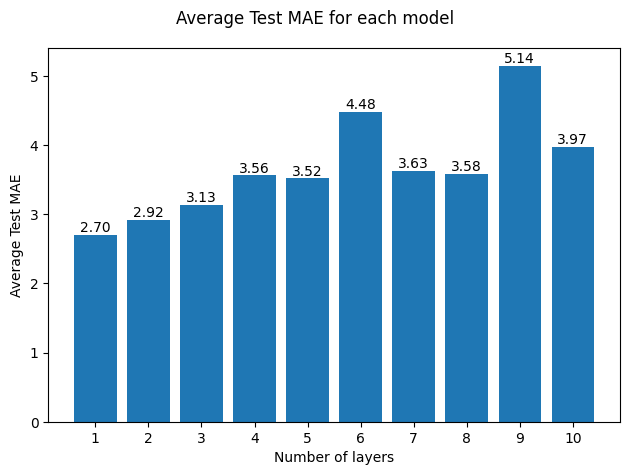

In [99]:
# Plot bar chart with average MAE for test data for each model
plt.figure()
n_layers = [len(architecture['layers']) - 2 for architecture in architectures]
average_test_scores = [np.mean(test_scores) for test_scores in all_test_scores]
plt.bar(n_layers, average_test_scores)
plt.xlabel('Number of layers')
plt.xticks(n_layers)
plt.ylabel('Average Test MAE')

# Plot the values on top of the bars
for i, score in enumerate(average_test_scores):
    plt.text(n_layers[i], score, f'{score:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('./imgs/average_test_mae_by_layer.png')
plt.suptitle('Average Test MAE for each model')
plt.tight_layout()
plt.show()

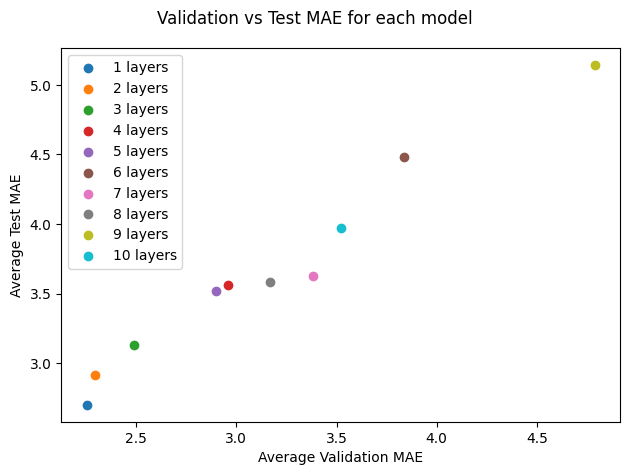

In [100]:
# Plot validation score vs test score for each model
plt.figure()
for i, scores in enumerate(all_scores):
    n_layers = len(architectures[i]['layers']) - 2
    plt.scatter(np.mean(scores), np.mean(all_test_scores[i]), label=f'{n_layers} layers')
plt.xlabel('Average Validation MAE')
plt.ylabel('Average Test MAE')
plt.legend()
plt.tight_layout()
plt.savefig('./imgs/validation_vs_test_mae_by_layer.png')
plt.suptitle('Validation vs Test MAE for each model')
plt.tight_layout()
plt.show()

### Análise

Com base nos resultados obtidos, é possível observar que a medida que aumentamos o número de camadas da rede, o *overfitting* da rede aumenta (obser a tendência de crescimento do erro no gráfico de barras). Isso ocorre porque a rede passa a ter mais parâmetros para ajustar, o que pode levar a um ajuste excessivo dos dados de treinamento.